In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

from imutils import paths
from pathlib import Path
import os
import sys
import time
import copy

import pandas as pd
import matplotlib.pylab as plt
import numpy as np

# Local modules
from cub_tools.train import train_model
from cub_tools.visualize import imshow, visualize_model
from cub_tools.utils import unpickle, save_pickle
from cub_tools.transforms import makeDefaultTransforms

In [2]:
# Script runtime options
model = 'vit_base_patch16_224'
data_root_dir = '../data'
model_root_dir = '../models'
stages = ['test']


# Paths setup
data_dir = os.path.join(data_root_dir,'images')
output_dir = os.path.join(model_root_dir,'classification/{}'.format(model))
model_history = os.path.join(output_dir,'model_history.pkl')
model_file = os.path.join(output_dir, 'caltech_birds_{}_full.pth'.format(model))

In [9]:
# Get data transforms
data_transforms = makeDefaultTransforms()

In [10]:
# Setup data loaders with augmentation transforms
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in stages}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in stages}
dataset_sizes = {x: len(image_datasets[x]) for x in stages}
class_names = image_datasets[stages[0]].classes

print('Number of data')
print('========================================')
for dataset in dataset_sizes.keys():
    print(dataset,' size:: ', dataset_sizes[dataset],' images')

print('')
print('Number of classes:: ', len(class_names))
print('========================================')
for i_class, class_name in enumerate(class_names):
    print('{} :: {} :: {}'.format(i_class,class_name,(np.array(image_datasets['test'].targets) == i_class).sum()))


Number of data
test  size::  5794  images

Number of classes::  200
0 :: 001.Black_footed_Albatross :: 30
1 :: 002.Laysan_Albatross :: 30
2 :: 003.Sooty_Albatross :: 28
3 :: 004.Groove_billed_Ani :: 30
4 :: 005.Crested_Auklet :: 14
5 :: 006.Least_Auklet :: 11
6 :: 007.Parakeet_Auklet :: 23
7 :: 008.Rhinoceros_Auklet :: 18
8 :: 009.Brewer_Blackbird :: 29
9 :: 010.Red_winged_Blackbird :: 30
10 :: 011.Rusty_Blackbird :: 30
11 :: 012.Yellow_headed_Blackbird :: 26
12 :: 013.Bobolink :: 30
13 :: 014.Indigo_Bunting :: 30
14 :: 015.Lazuli_Bunting :: 28
15 :: 016.Painted_Bunting :: 28
16 :: 017.Cardinal :: 27
17 :: 018.Spotted_Catbird :: 15
18 :: 019.Gray_Catbird :: 29
19 :: 020.Yellow_breasted_Chat :: 29
20 :: 021.Eastern_Towhee :: 30
21 :: 022.Chuck_will_Widow :: 26
22 :: 023.Brandt_Cormorant :: 29
23 :: 024.Red_faced_Cormorant :: 22
24 :: 025.Pelagic_Cormorant :: 30
25 :: 026.Bronzed_Cowbird :: 30
26 :: 027.Shiny_Cowbird :: 30
27 :: 028.Brown_Creeper :: 29
28 :: 029.American_Crow :: 30
29 ::

In [11]:
# Setup the device to run the computations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device::', device)

Device:: cuda:0


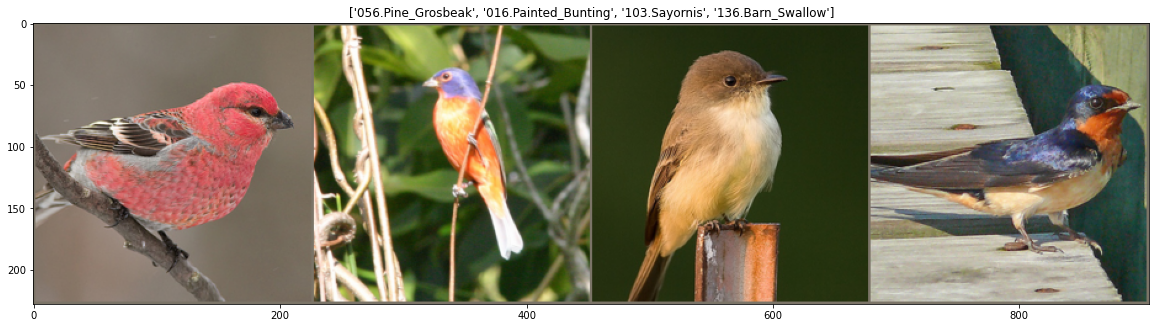

In [12]:
# Check the augmentations
# Get a batch of training data
inputs, classes = next(iter(dataloaders['test']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [13]:
# Load the best model from file
model_ = torch.load(model_file)

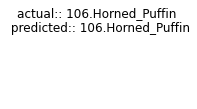

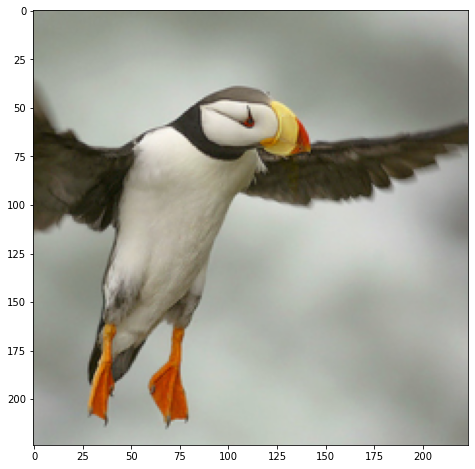

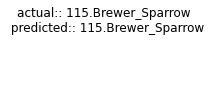

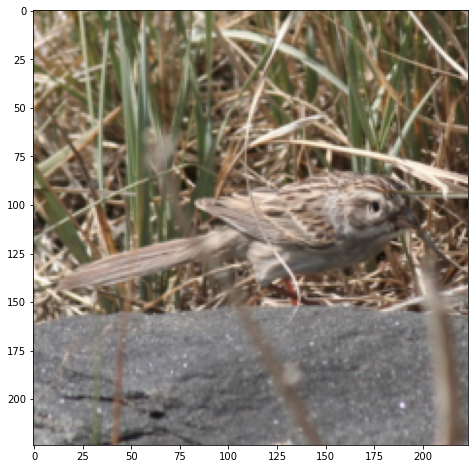

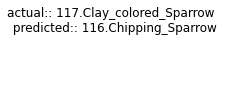

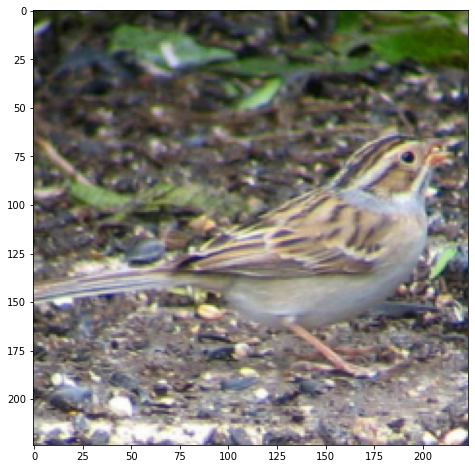

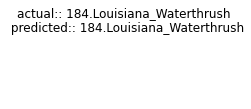

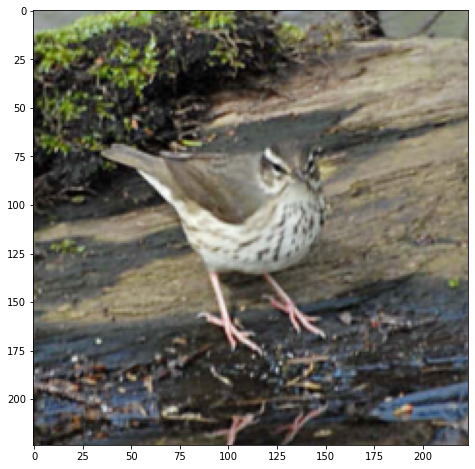

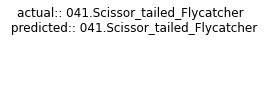

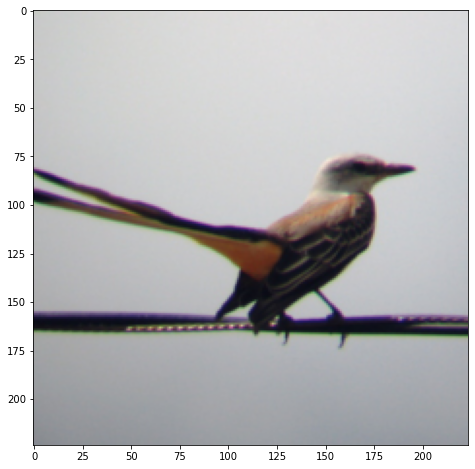

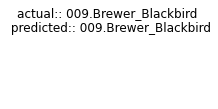

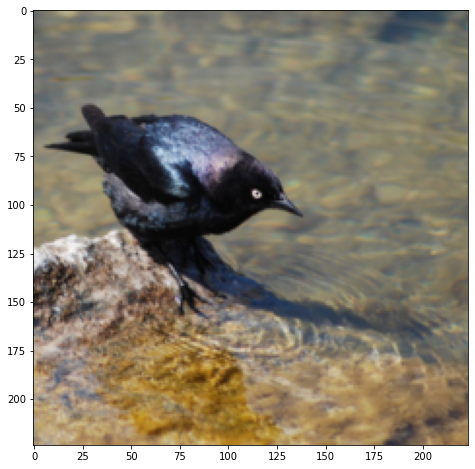

In [14]:
visualize_model(model=model_, class_names=class_names, device=device, dataloaders=dataloaders)

In [15]:
# Load model training history
history = unpickle(model_history)

In [16]:
for key in history.keys():
    print(' {} Type :: {}'.format(key,type(history[key][0])))

 epoch Type :: <class 'int'>
 train_loss Type :: <class 'float'>
 test_loss Type :: <class 'float'>
 train_acc Type :: <class 'torch.Tensor'>
 test_acc Type :: <class 'torch.Tensor'>


In [17]:
for key in history.keys():
    print(' {} Type :: {}'.format(key,type(history[key][0])))
    if (torch.is_tensor(history[key][0])) and (history[key][0].device.type == 'cuda'):
        print('Converting Tensor type from GPU to CPU')
        for i, item in enumerate(history[key]):
            history[key][i] = history[key][i].cpu().tolist()

 epoch Type :: <class 'int'>
 train_loss Type :: <class 'float'>
 test_loss Type :: <class 'float'>
 train_acc Type :: <class 'torch.Tensor'>
Converting Tensor type from GPU to CPU
 test_acc Type :: <class 'torch.Tensor'>
Converting Tensor type from GPU to CPU


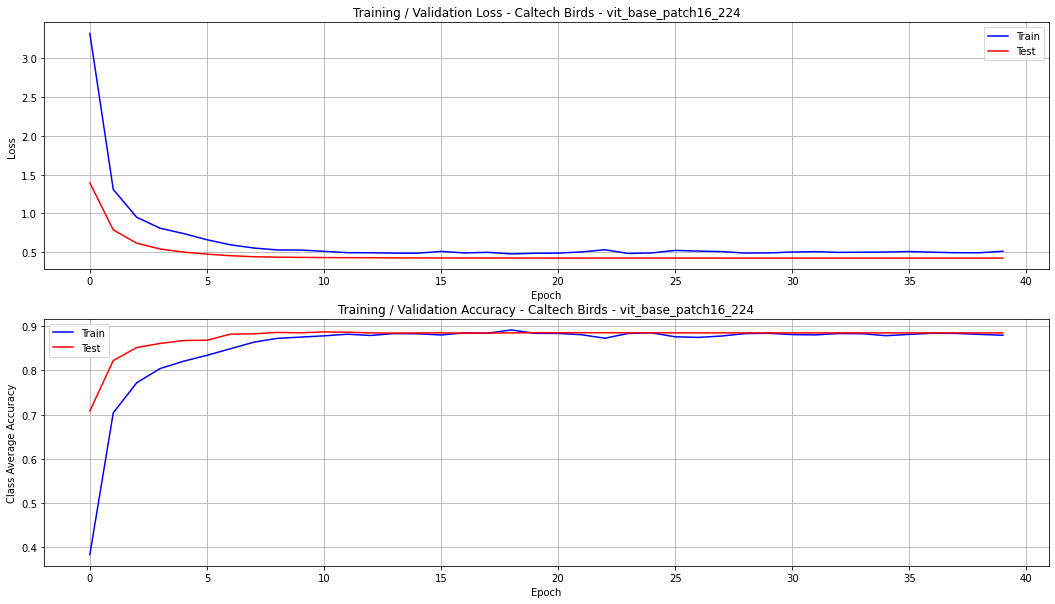

In [18]:
plt.figure(figsize=(18,10))

plt.subplot(2,1,1)
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['train_loss'], 'b-', label='Train')
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['test_loss'], 'r-', label='Test')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training / Validation Loss - Caltech Birds - {}'.format(model))
plt.legend()

plt.subplot(2,1,2)
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['train_acc'], 'b-', label='Train')
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['test_acc'], 'r-', label='Test')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Class Average Accuracy')
plt.title('Training / Validation Accuracy - Caltech Birds - {}'.format(model))
plt.legend()

plt.show()

In [19]:
was_training = model_.training
model_.eval()
images_so_far = 0


print('Commencing predictions minibatch..', end='')
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
        if i % 25 == 0:
            print('{}..'.format(i), end='')

        inputs = inputs.to(device)
        labels = labels.to(device)
        

        outputs = model_(inputs)
        _, preds = torch.max(outputs, 1)

        if i == 0:
            labels_truth = labels.cpu().numpy()
            labels_pred = preds.cpu().numpy()
            scores_pred = outputs.cpu().numpy()
        else:
            labels_truth = np.concatenate((labels_truth,labels.cpu().numpy()))
            labels_pred = np.concatenate((labels_pred,preds.cpu().numpy()))
            scores_pred= np.concatenate((scores_pred,outputs.cpu().numpy()))

print('Complete.')

results_dict = {'labels truth' : labels_truth, 'labels pred' : labels_pred, 'scores pred' : scores_pred}

Commencing predictions minibatch..0..25..50..75..100..125..150..175..200..225..250..275..300..325..350..375..400..425..450..475..500..525..550..575..600..625..650..675..700..725..750..775..800..825..850..875..900..925..950..975..1000..1025..1050..1075..1100..1125..1150..1175..1200..1225..1250..1275..1300..1325..1350..1375..1400..1425..Complete.


In [20]:
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

In [21]:
print(classification_report(y_true=labels_truth, y_pred=labels_pred, target_names=class_names))

                                    precision    recall  f1-score   support

        001.Black_footed_Albatross       0.93      0.90      0.92        30
              002.Laysan_Albatross       0.89      0.83      0.86        30
               003.Sooty_Albatross       0.81      0.89      0.85        28
             004.Groove_billed_Ani       0.94      1.00      0.97        30
                005.Crested_Auklet       0.92      0.86      0.89        14
                  006.Least_Auklet       1.00      1.00      1.00        11
               007.Parakeet_Auklet       0.96      1.00      0.98        23
             008.Rhinoceros_Auklet       0.85      0.94      0.89        18
              009.Brewer_Blackbird       0.62      0.55      0.58        29
          010.Red_winged_Blackbird       0.97      1.00      0.98        30
               011.Rusty_Blackbird       0.88      0.70      0.78        30
       012.Yellow_headed_Blackbird       1.00      1.00      1.00        26
           

In [22]:
class_report_df = pd.DataFrame(classification_report(y_true=labels_truth, y_pred=labels_pred, target_names=class_names, output_dict=True))
class_report_df

001.Black_footed_Albatross  002.Laysan_Albatross  \
precision                    0.931034              0.892857   
recall                       0.900000              0.833333   
f1-score                     0.915254              0.862069   
support                     30.000000             30.000000   

           003.Sooty_Albatross  004.Groove_billed_Ani  005.Crested_Auklet  \
precision             0.806452               0.937500            0.923077   
recall                0.892857               1.000000            0.857143   
f1-score              0.847458               0.967742            0.888889   
support              28.000000              30.000000           14.000000   

           006.Least_Auklet  007.Parakeet_Auklet  008.Rhinoceros_Auklet  \
precision               1.0             0.958333               0.850000   
recall                  1.0             1.000000               0.944444   
f1-score                1.0             0.978723               0.894737   
support                11.0            23.000000              18.000000   

           009.Brewer_Blackbird  010.Red_winged_Blackbird  ...  \
precision              0.615385                  0.967742  ...   
recall                 0.551724                  1.000000  ...   
f1-score               0.581818                  0.983607  ...   
support               29.000000                 30.000000  ...   

           194.Cactus_Wren  195.Carolina_Wren  196.House_Wren  197.Marsh_Wren  \
precision              1.0           0.805556        0.848485        1.000000   
recall                 1.0           0.966667        0.933333        0.866667   
f1-score               1.0           0.878788        0.888889        0.928571   
support               30.0          30.000000       30.000000       30.000000   

           198.Rock_Wren  199.Winter_Wren  200.Common_Yellowthroat  accuracy  \
precision       1.000000         0.928571                 0.909091  0.887125   
recall          0.966667         0.866667                 1.000000  0.887125   
f1-score        0.983051         0.896552                 0.952381  0.887125   
support        30.000000        30.000000                30.000000  0.887125   

             macro avg  weighted avg  
precision     0.889429      0.889223  
recall        0.887682      0.887125  
f1-score      0.885827      0.885414  
support    5794.000000   5794.000000  

[4 rows x 203 columns]

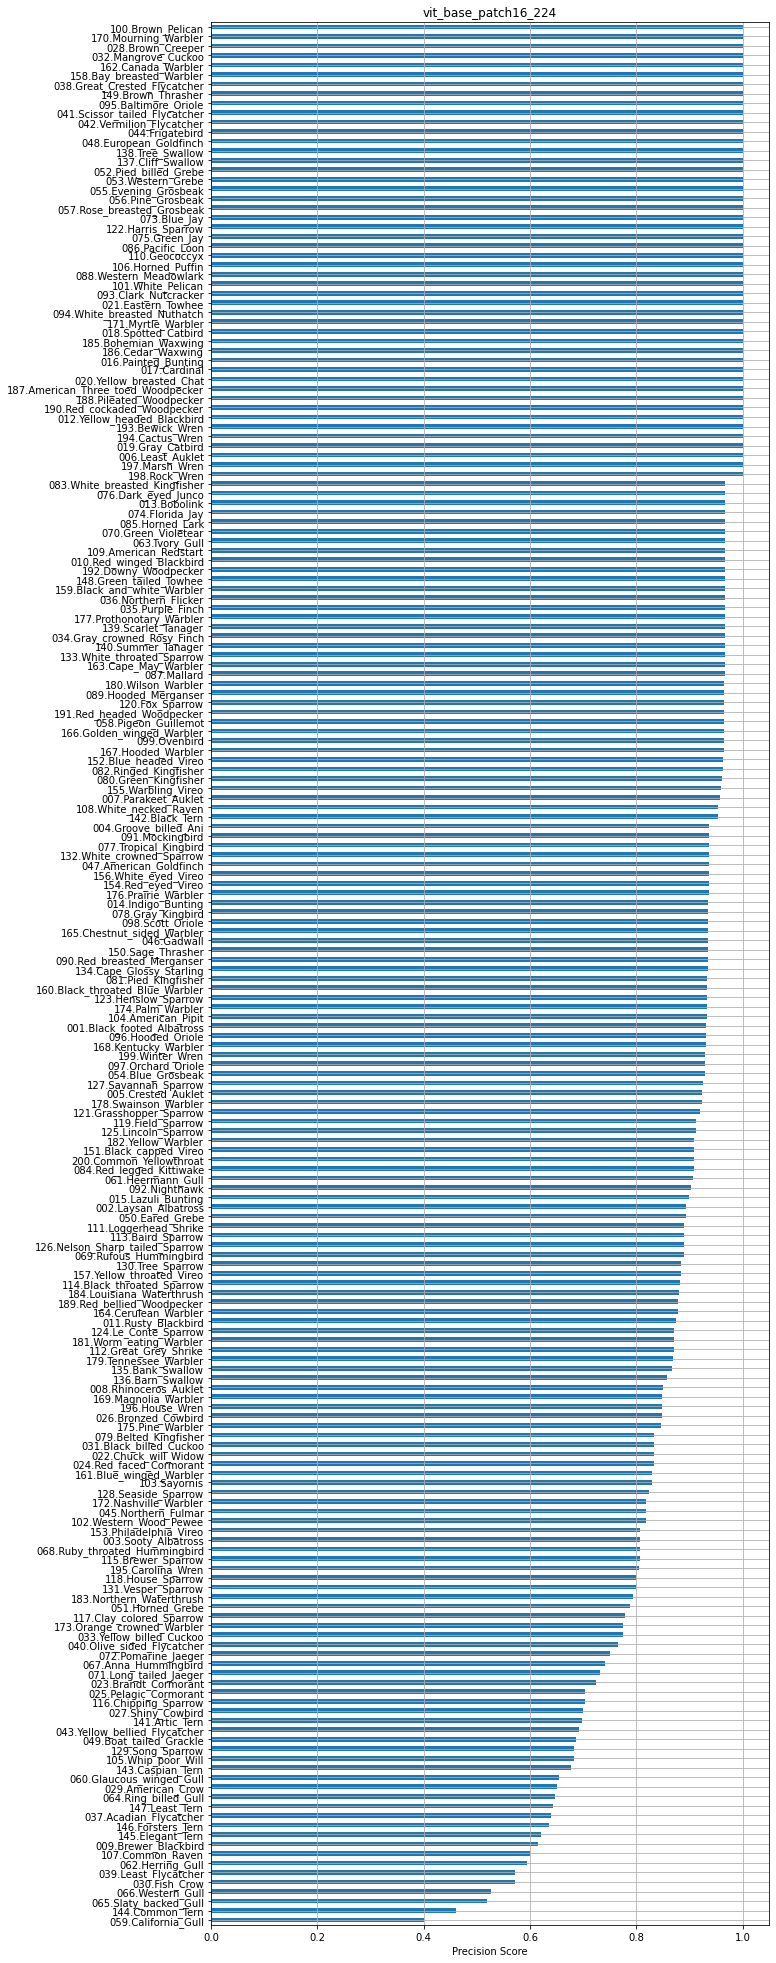

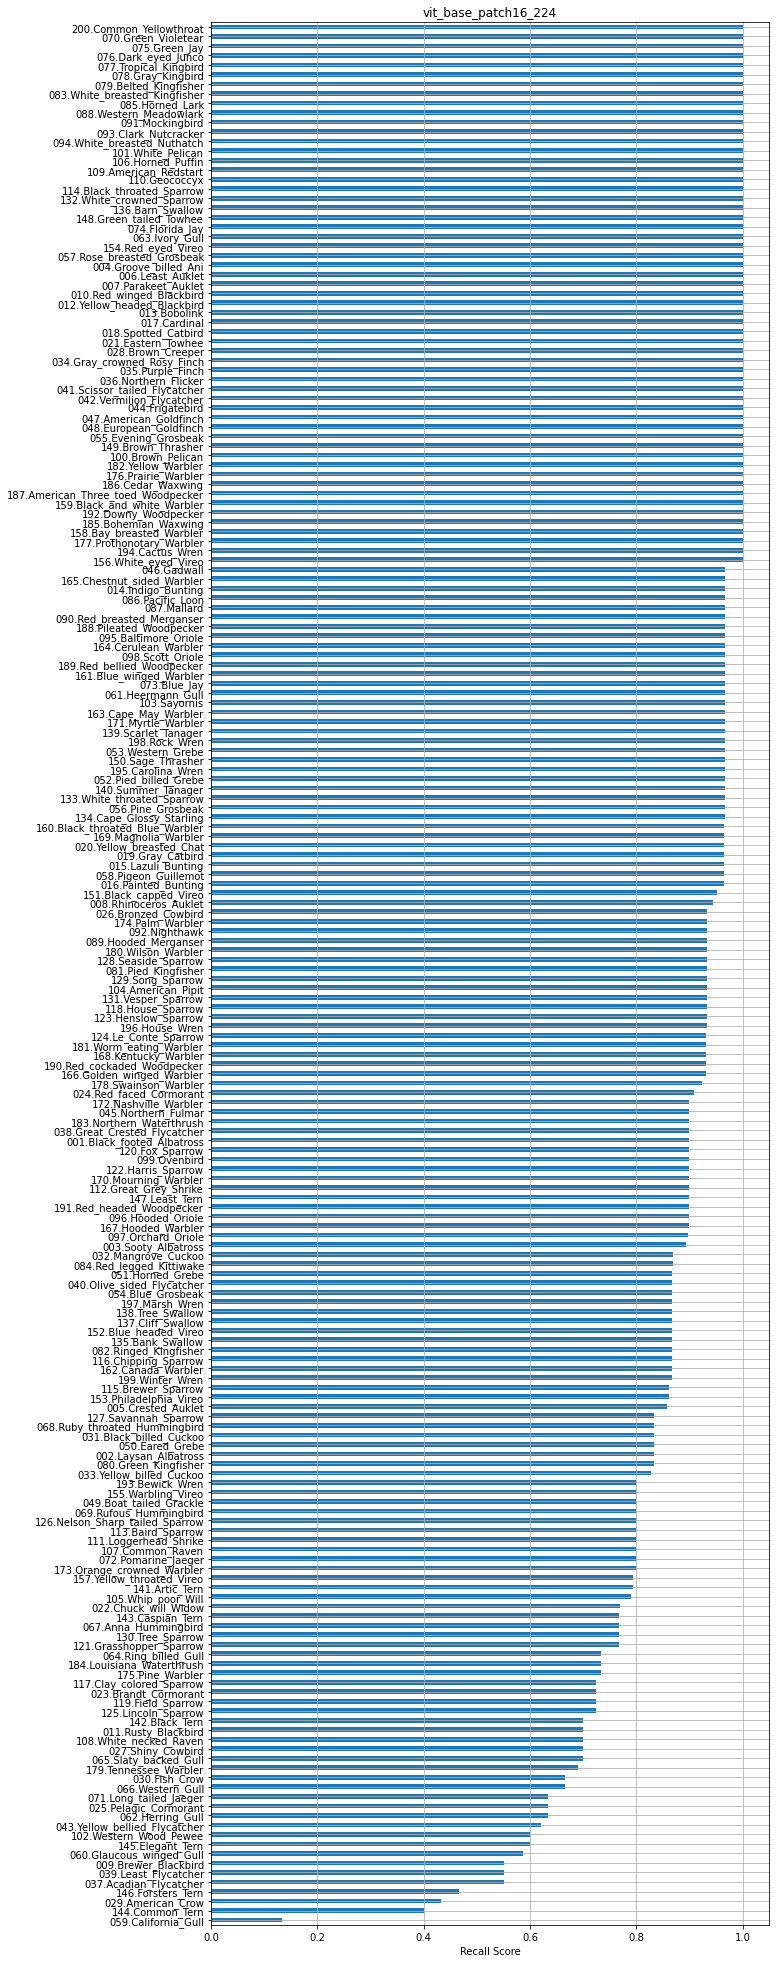

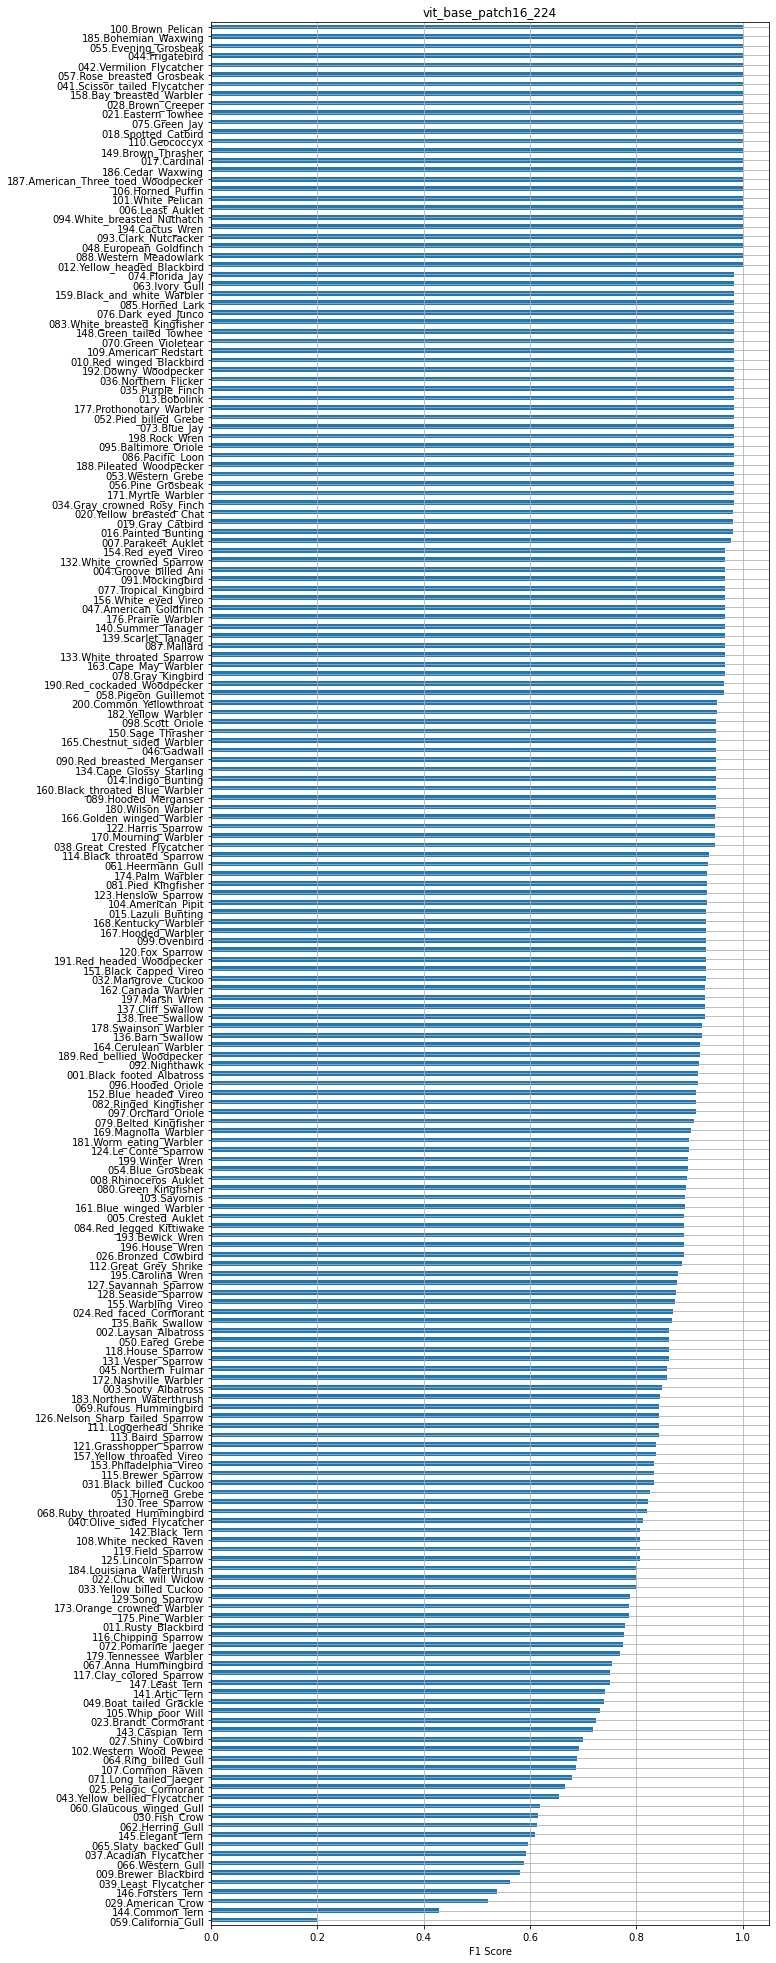

In [23]:
plt.figure(figsize=(10,35))
class_report_df.transpose()['precision'][:-3].sort_values().plot(kind='barh')
plt.xlabel('Precision Score')
plt.grid(True)
plt.title(model)

plt.figure(figsize=(10,35))
class_report_df.transpose()['recall'][:-3].sort_values().plot(kind='barh')
plt.xlabel('Recall Score')
plt.title(model)
plt.grid(True)

plt.figure(figsize=(10,35))
class_report_df.transpose()['f1-score'][:-3].sort_values().plot(kind='barh')
plt.xlabel('F1 Score')
plt.title(model)
plt.grid(True)

plt.show()

In [24]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true=labels_truth, y_pred=labels_pred), index=class_names, columns=class_names)

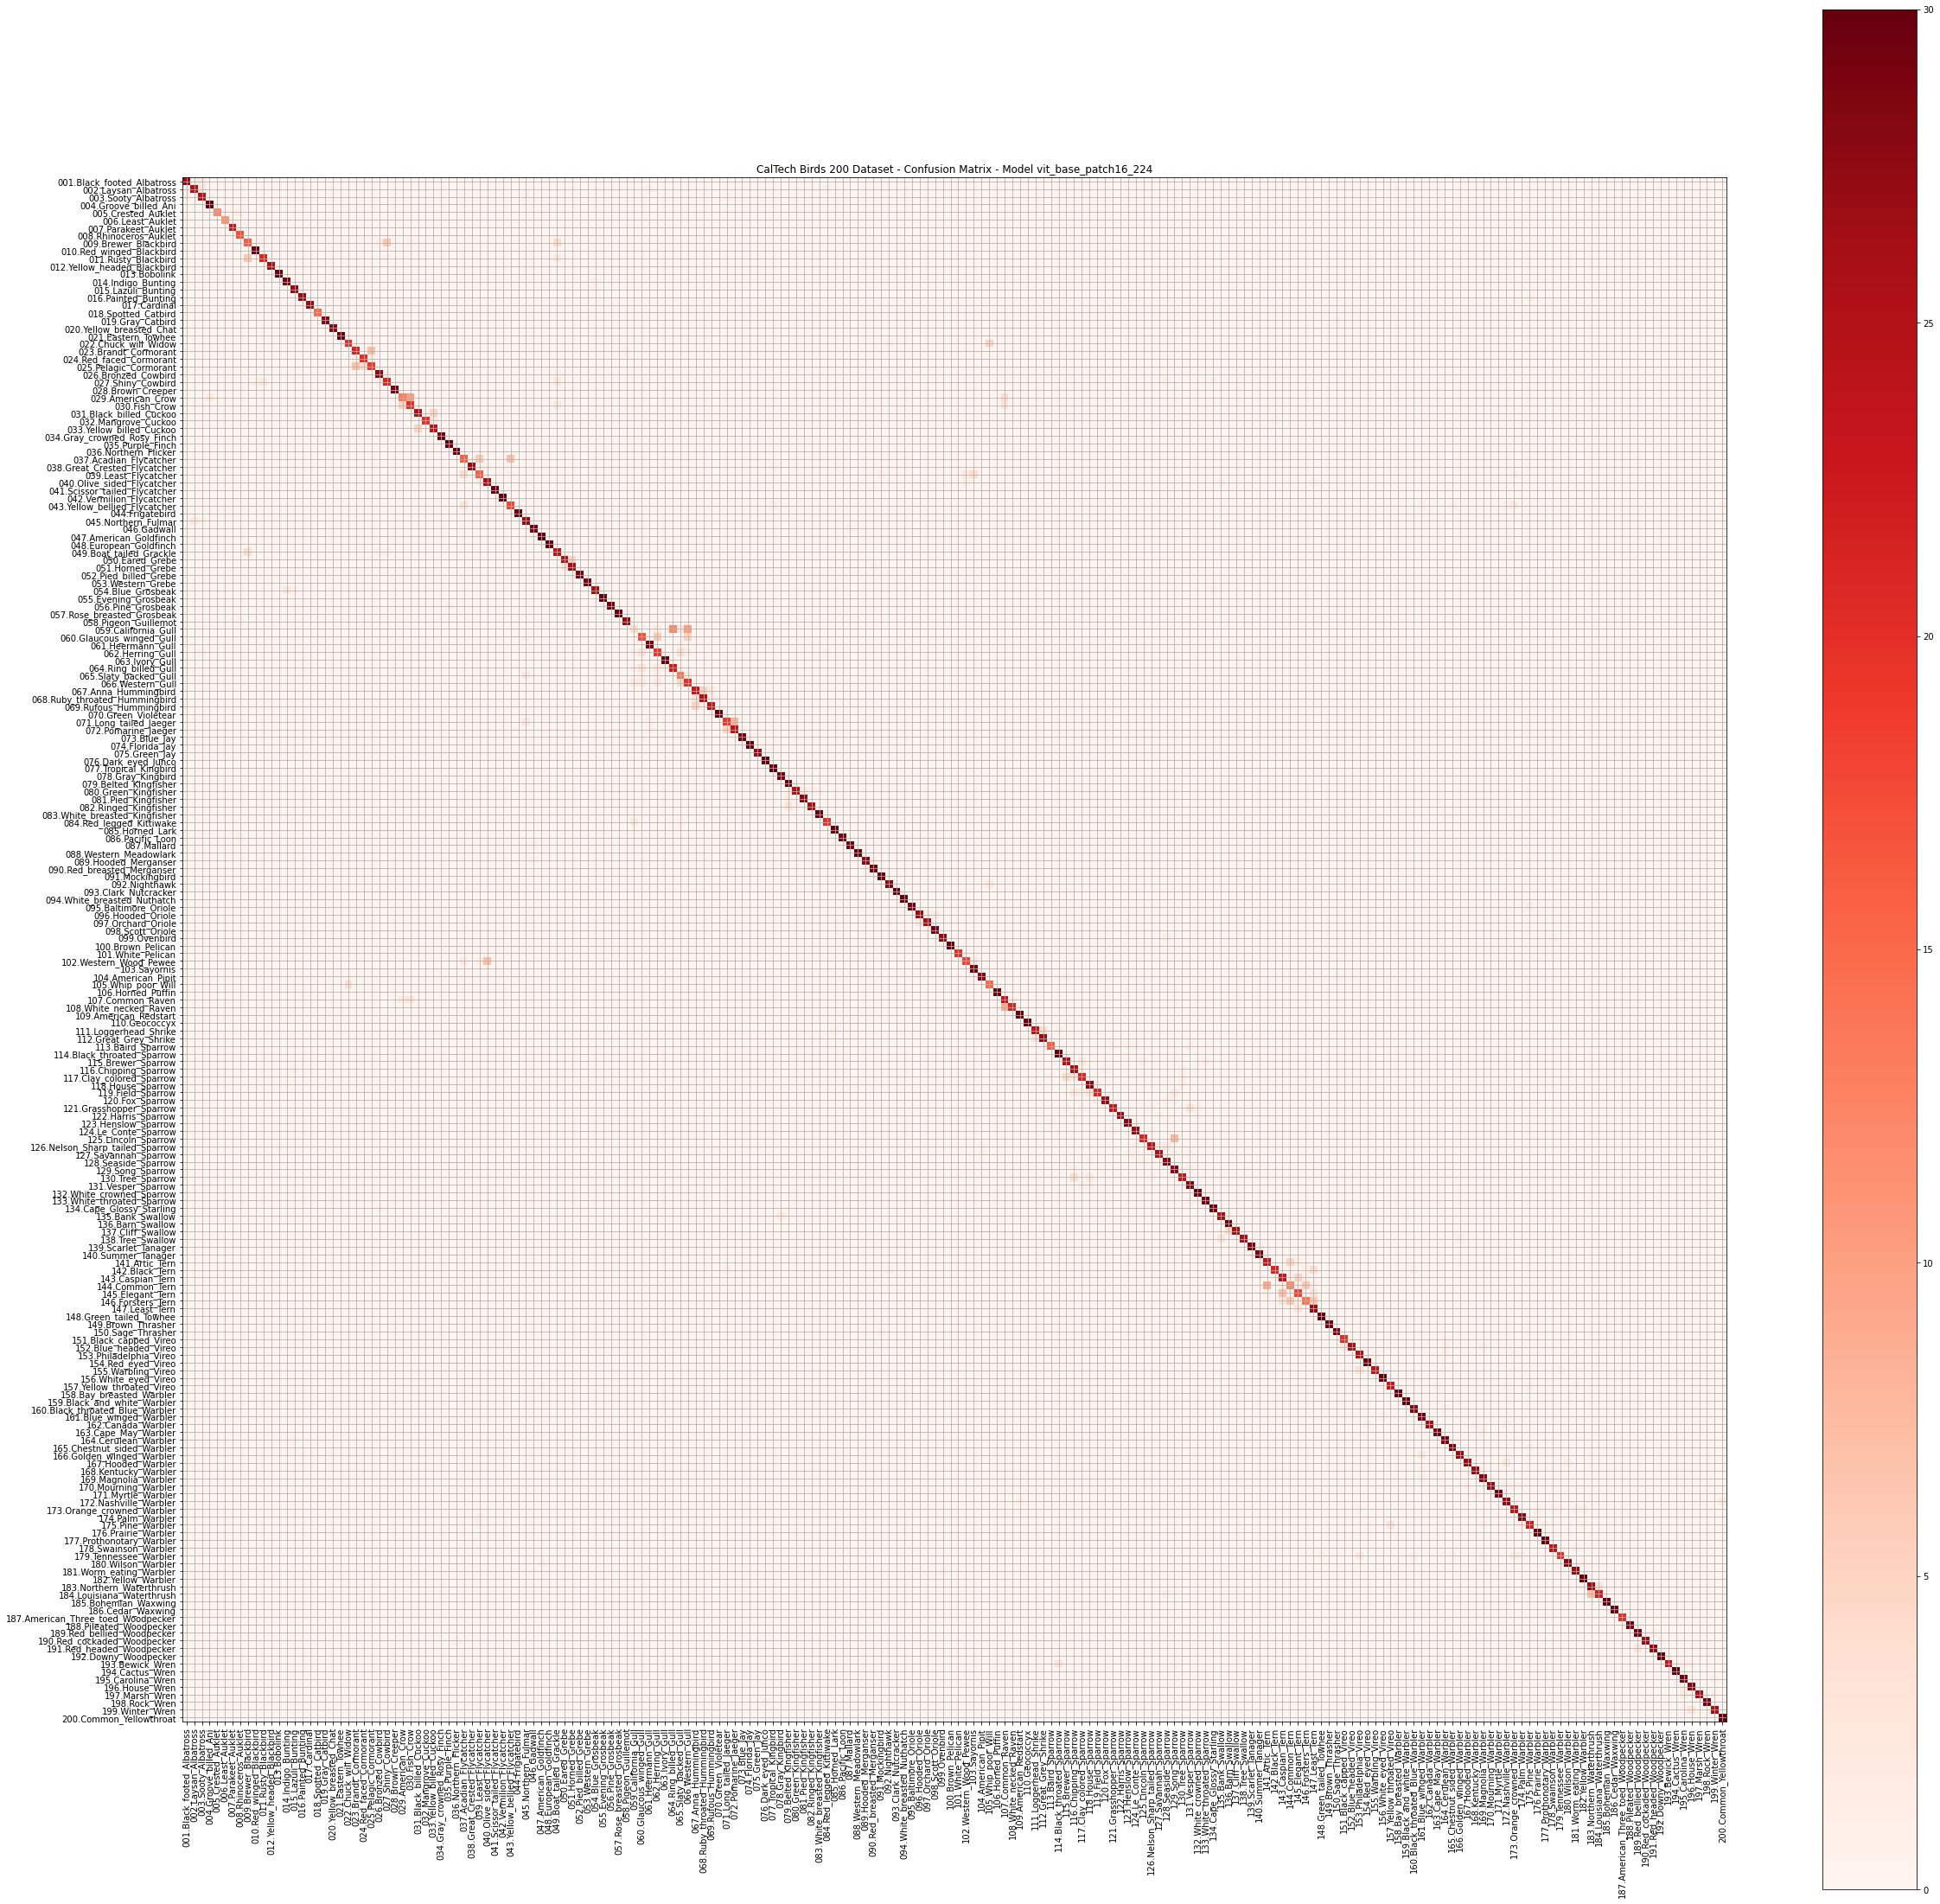

In [25]:
plt.figure(figsize=(40,40))
plt.imshow(confusion_matrix_df, cmap='Reds')
plt.xticks(np.arange(0,len(class_names),1), class_names, rotation=90)
plt.yticks(np.arange(0,len(class_names),1), class_names)
plt.colorbar()
plt.grid(True)
plt.title('CalTech Birds 200 Dataset - Confusion Matrix - Model {}'.format(model))
plt.show()

In [26]:
class_report_df.to_pickle(os.path.join(output_dir,'classification_report.pkl'))
confusion_matrix_df.to_pickle(os.path.join(output_dir,'confusion_matrix.pkl'))
save_pickle(pkl_object=results_dict, fname=os.path.join(output_dir,'model_results.pkl'))

In [27]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [28]:
results_dict.keys()

dict_keys(['labels truth', 'labels pred', 'scores pred'])

In [29]:
results_dict['scores pred'].shape

(5794, 200)

In [30]:
misclass_scores = []
for i in range(results_dict['scores pred'].shape[0]):
    if results_dict['labels truth'][i] != results_dict['labels pred'][i]:
        misclass_scores.append( 
            {
                'label truth' : results_dict['labels truth'][i],
                'label pred' : results_dict['labels pred'][i],
                'scores' : softmax(results_dict['scores pred'][i,:])
            }
        )

In [31]:
pd.DataFrame(misclass_scores)

label truth  label pred  \
0             50          89   
1            104          21   
2            189         191   
3             70          71   
4             68          66   
..           ...         ...   
649           38         102   
650          143         142   
651          126         130   
652          122         112   
653            8          10   

                                                scores  
0    [0.00024099776, 0.00031109728, 0.00011167685, ...  
1    [2.5234418e-05, 1.5442341e-05, 6.5975996e-06, ...  
2    [1.8360972e-05, 3.029016e-05, 1.8149594e-05, 1...  
3    [0.0005354755, 0.00015656279, 0.0009898853, 1....  
4    [4.316674e-05, 2.866357e-05, 7.586822e-05, 2.7...  
..                                                 ...  
649  [2.3421462e-05, 2.0628202e-05, 3.3919892e-05, ...  
650  [0.00015092462, 0.00039776592, 0.0018364924, 9...  
651  [1.2936385e-05, 1.4868871e-05, 1.9464356e-05, ...  
652  [7.237708e-05, 2.4890911e-05, 3.6352387e-05, 2...  
653  [9.908802e-05, 1.215727e-05, 1.3976756e-05, 2....  

[654 rows x 3 columns]

In [32]:
misclass_scores_array = []
for m in misclass_scores:
    misclass_scores_array.append( m['scores'] )
misclass_scores_array = np.asarray(misclass_scores_array)

In [33]:
misclass_scores_array.shape

(654, 200)

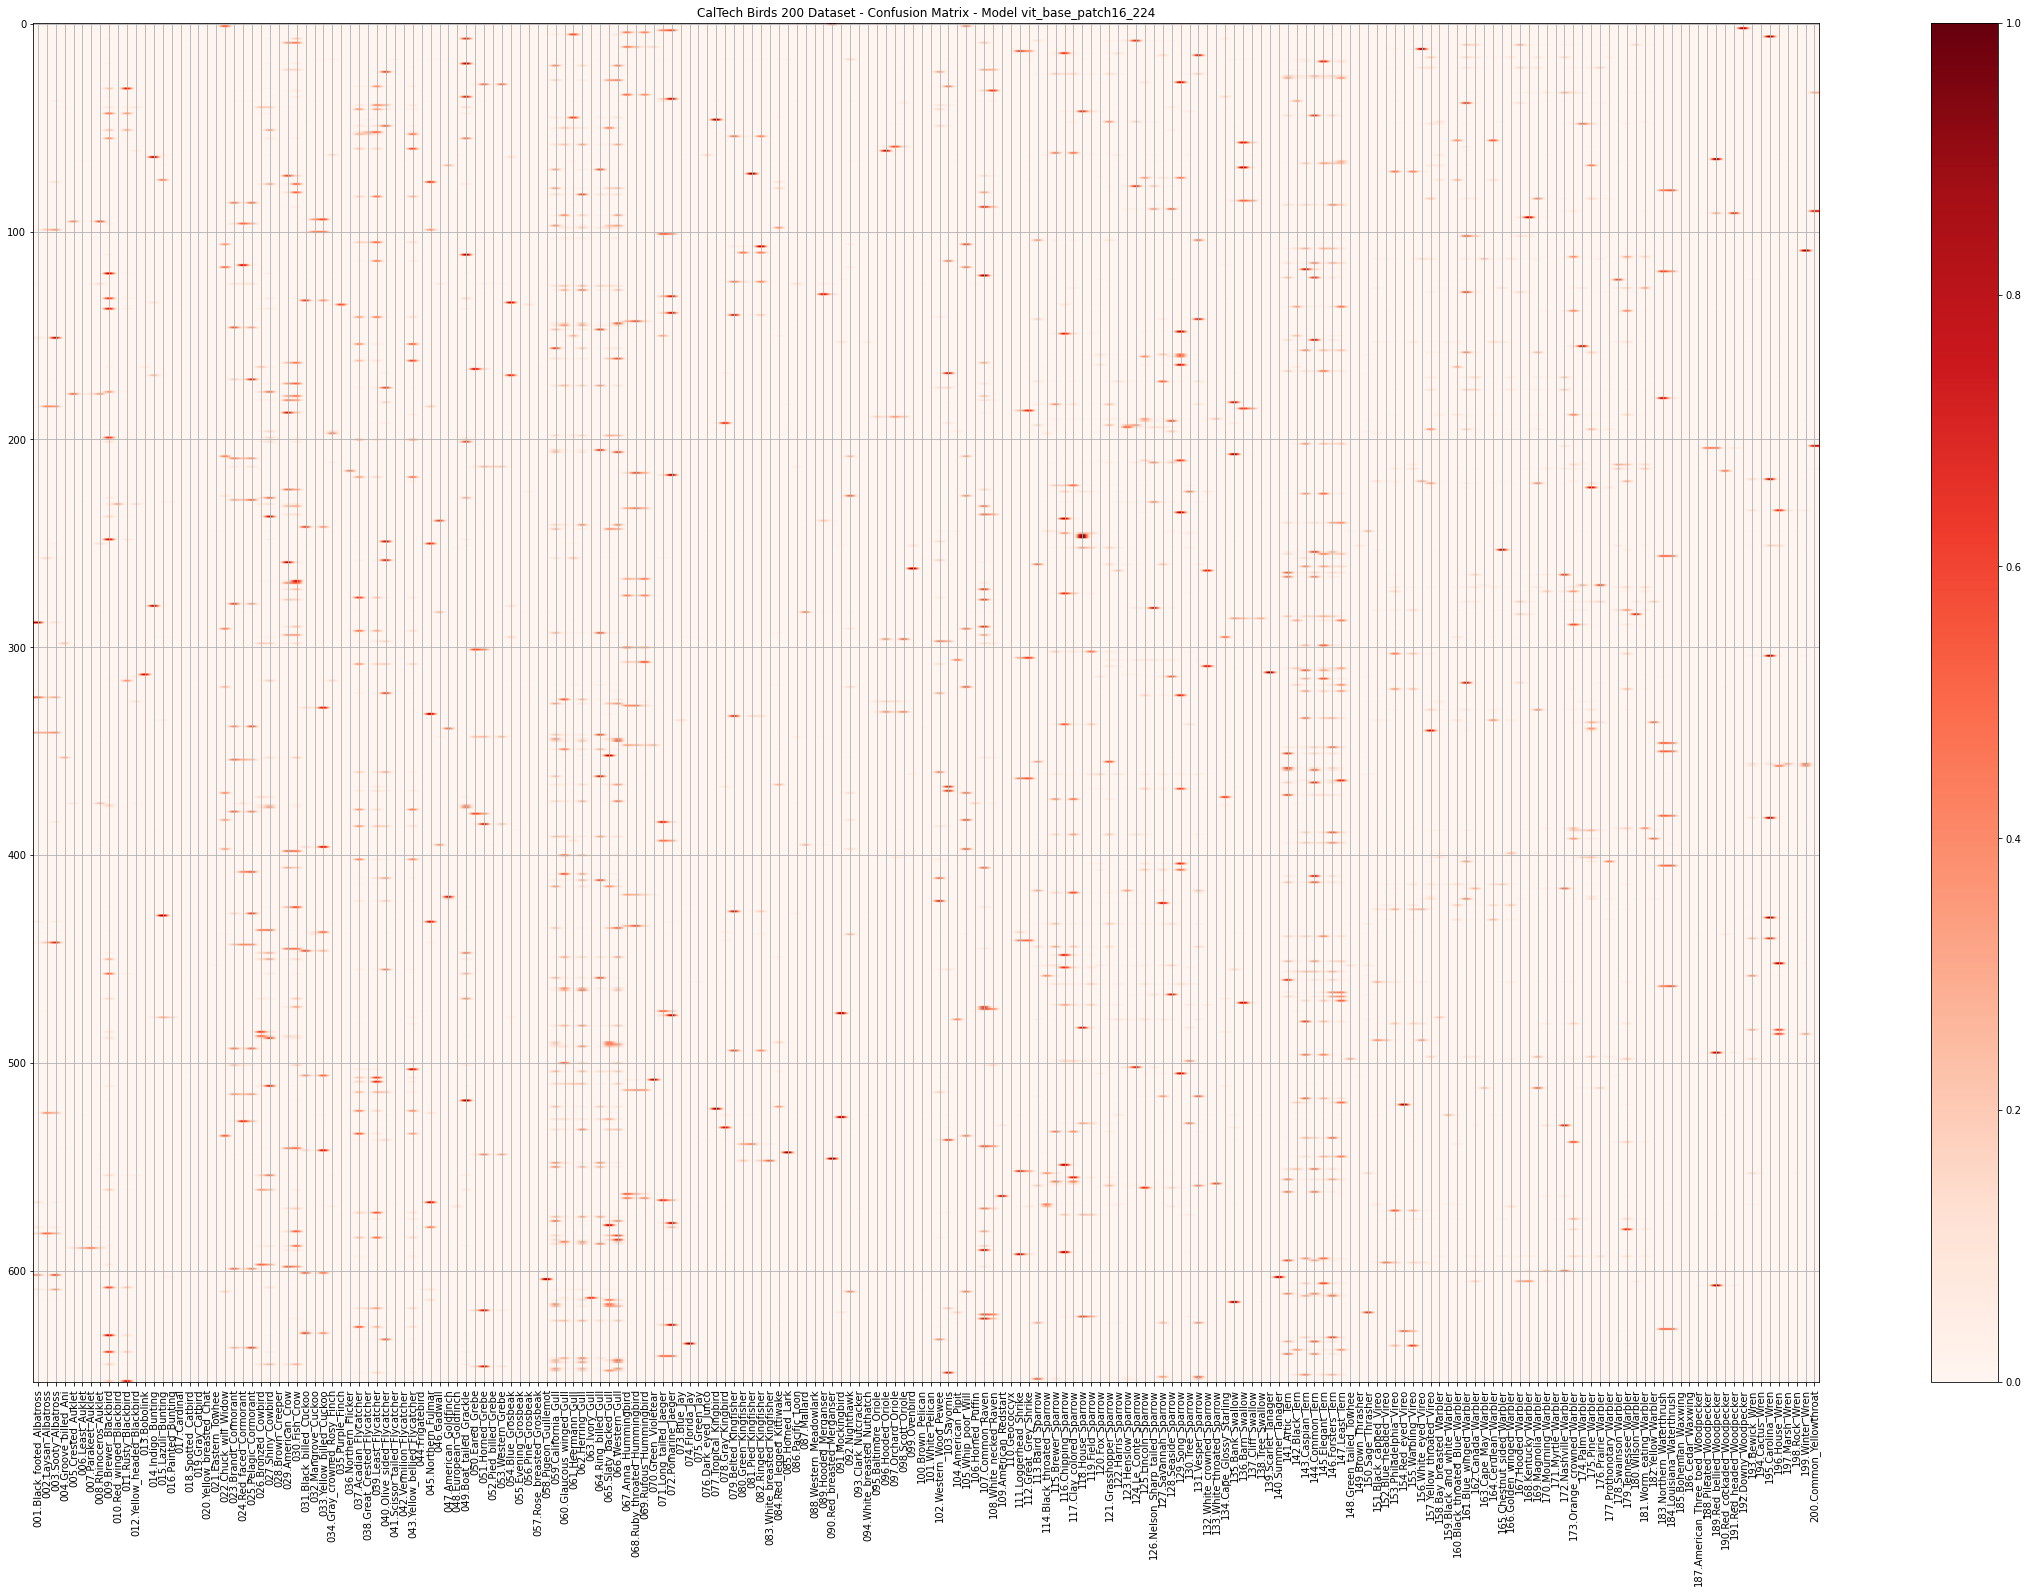

In [34]:
plt.figure(figsize=(40,25))
plt.imshow(misclass_scores_array, cmap='Reds', aspect='auto')
plt.xticks(np.arange(0,len(class_names),1), class_names, rotation=90)
#plt.yticks(np.arange(0,len(class_names),1), class_names)
plt.colorbar()
plt.grid(True)
plt.title('CalTech Birds 200 Dataset - Confusion Matrix - Model {}'.format(model))
plt.clim([0,1.0])
plt.show()

In [35]:
test_img_i = 5

results = softmax(results_dict['scores pred'][test_img_i])

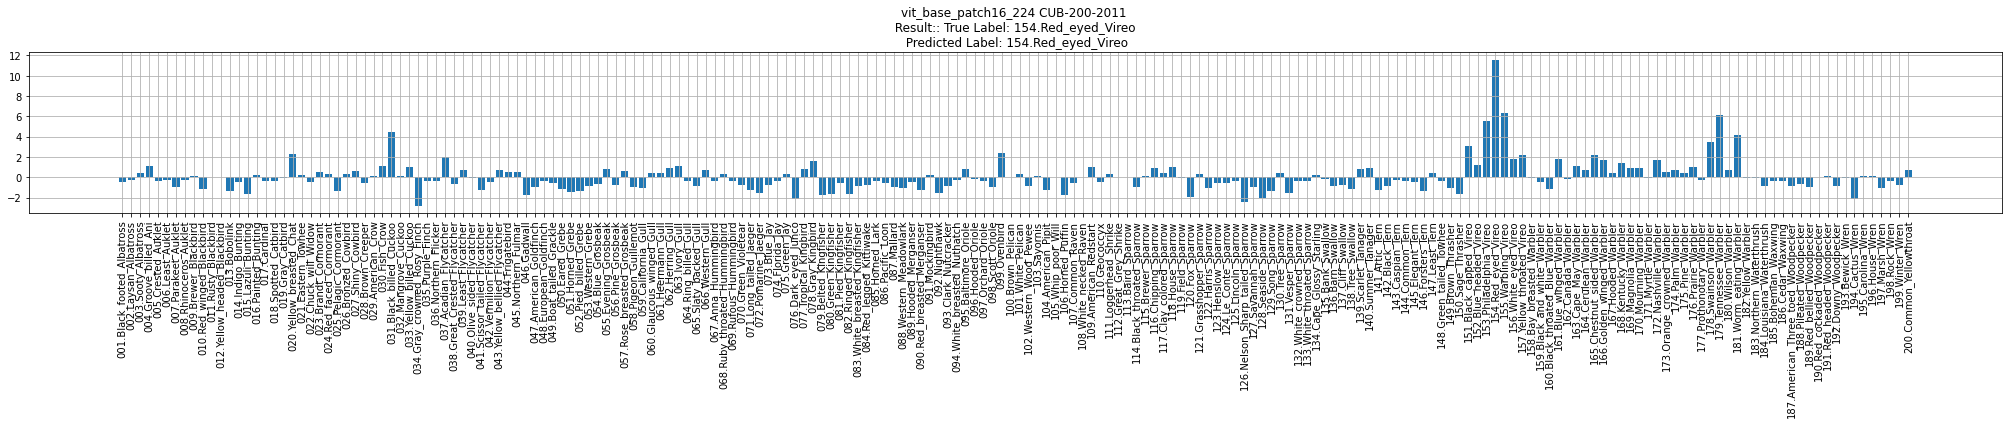

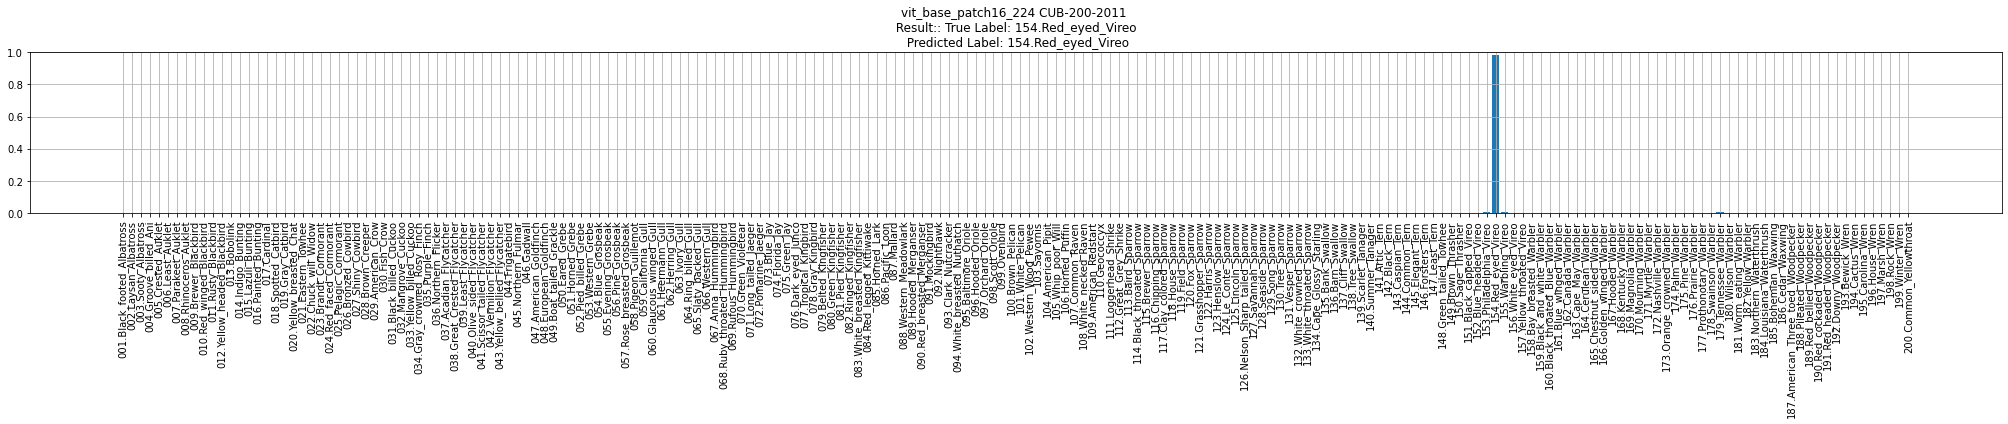

In [36]:
plt.figure(figsize=(28,6))
plt.bar(class_names,height=results_dict['scores pred'][test_img_i])
plt.xticks(rotation=90)
plt.title('{} CUB-200-2011 \n Result:: True Label: {} \n Predicted Label: {}'.format(model, class_names[results_dict['labels truth'][test_img_i]], class_names[results_dict['labels pred'][test_img_i]]))
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(28,6))
plt.bar(class_names,height=results)
plt.xticks(rotation=90)
plt.title('{} CUB-200-2011 \n Result:: True Label: {} \n Predicted Label: {}'.format(model, class_names[results_dict['labels truth'][test_img_i]], class_names[results_dict['labels pred'][test_img_i]]))
plt.grid(True)
plt.tight_layout()
plt.ylim([0.0, 1.0])
plt.show()